In [23]:
# Ignore warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

# for area calculation
import pyproj
from shapely.geometry import Polygon
from shapely.ops import transform



#Process data    
import numpy as np
import xarray as xr

#Display data 
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.vector_transform import vector_scalar_to_grid
from matplotlib.axes import Axes
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.image as image
import matplotlib.pyplot as plt

#Writing data files
import pandas as pd
import copy

In [24]:
def utm_epsg(lon: float, lat: float) -> int:
  """
  Return the UTM EPSG code for the given lon-lat.
  """
  offset = int(round((183 + lon) / 6.0))
  return 32600 + offset if lat > 0 else 32700 + offset

In [25]:
fn1 = '/media/Data1/Climada/ISIMIP/data/landuse-15crops_2015soc_annual_1850_2014.nc'
ds=xr.open_dataset(fn1,decode_times=False)
ds

<xarray.Dataset>
Dimensions:                        (time: 165, lon: 720, lat: 360)
Coordinates:
  * time                           (time) float64 189.0 190.0 ... 352.0 353.0
  * lon                            (lon) float64 -179.8 -179.2 ... 179.2 179.8
  * lat                            (lat) float64 89.75 89.25 ... -89.25 -89.75
Data variables: (12/31)
    c3per_irrigated                (time, lat, lon) float32 ...
    c3per_rainfed                  (time, lat, lon) float32 ...
    c4per_irrigated                (time, lat, lon) float32 ...
    c4per_rainfed                  (time, lat, lon) float32 ...
    maize_irrigated                (time, lat, lon) float32 ...
    maize_rainfed                  (time, lat, lon) float32 ...
    ...                             ...
    temperate_roots_irrigated      (time, lat, lon) float32 ...
    temperate_roots_rainfed        (time, lat, lon) float32 ...
    tropical_cereals_irrigated     (time, lat, lon) float32 ...
    tropical_cereals_rainfed       (time, lat, lon) float32 ...
    tropical_roots_irrigated       (time, lat, lon) float32 ...
    tropical_roots_rainfed         (time, lat, lon) float32 ...
Attributes:
    source:            Based on LUH2 v2h and Global Harvested Area for 175 crops
    institution:       Potsdam Institute for Climate Impact Research
    references:        Frieler et al., Geosci. Model Dev. Discuss., doi:10.51...
    comment:           LUH2 functional crop types disaggregated to 15 ISIMIP ...
    further_info_url:  http://www.isimip.org
    title:             ISIMIP2a ext historical land-use dataset
    contact:           info@isimip.org

In [26]:
ds.maize_rainfed.shape

(165, 360, 720)

In [27]:
#sub domain
min_lon = -100 
min_lat = 35
max_lon = -70
max_lat = 65 

cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))

In [28]:
cropped_ds.lon

<xarray.DataArray 'lon' (lon: 60)>
array([-99.75, -99.25, -98.75, -98.25, -97.75, -97.25, -96.75, -96.25, -95.75,
       -95.25, -94.75, -94.25, -93.75, -93.25, -92.75, -92.25, -91.75, -91.25,
       -90.75, -90.25, -89.75, -89.25, -88.75, -88.25, -87.75, -87.25, -86.75,
       -86.25, -85.75, -85.25, -84.75, -84.25, -83.75, -83.25, -82.75, -82.25,
       -81.75, -81.25, -80.75, -80.25, -79.75, -79.25, -78.75, -78.25, -77.75,
       -77.25, -76.75, -76.25, -75.75, -75.25, -74.75, -74.25, -73.75, -73.25,
       -72.75, -72.25, -71.75, -71.25, -70.75, -70.25])
Coordinates:
  * lon      (lon) float64 -99.75 -99.25 -98.75 -98.25 ... -71.25 -70.75 -70.25
Attributes:
    standard_name:  longitude
    long_name:      lon
    units:          degrees_east
    axis:           X

In [29]:
cropped_ds.lat

<xarray.DataArray 'lat' (lat: 60)>
array([64.75, 64.25, 63.75, 63.25, 62.75, 62.25, 61.75, 61.25, 60.75, 60.25,
       59.75, 59.25, 58.75, 58.25, 57.75, 57.25, 56.75, 56.25, 55.75, 55.25,
       54.75, 54.25, 53.75, 53.25, 52.75, 52.25, 51.75, 51.25, 50.75, 50.25,
       49.75, 49.25, 48.75, 48.25, 47.75, 47.25, 46.75, 46.25, 45.75, 45.25,
       44.75, 44.25, 43.75, 43.25, 42.75, 42.25, 41.75, 41.25, 40.75, 40.25,
       39.75, 39.25, 38.75, 38.25, 37.75, 37.25, 36.75, 36.25, 35.75, 35.25])
Coordinates:
  * lat      (lat) float64 64.75 64.25 63.75 63.25 ... 36.75 36.25 35.75 35.25
Attributes:
    standard_name:  latitude
    long_name:      lat
    units:          degrees_north
    axis:           Y

In [30]:
areainsqmeter=np.empty((60,60))
dd=0.25
i=0
for lat in cropped_ds.lat:
    j=0
    for lon in cropped_ds.lon:
        polygon = Polygon([
            [lon-dd, lat-dd],
            [lon-dd, lat+dd],
            [lon+dd, lat+dd],
            [lon+dd, lat-dd],
            [lon-dd, lat-dd],
        ])
        
        src_crs = pyproj.CRS.from_epsg(4326)
        tgt_crs = pyproj.CRS.from_epsg(utm_epsg(polygon.centroid.x, polygon.centroid.y))

        project = pyproj.Transformer.from_crs(src_crs, tgt_crs, always_xy=True).transform

        utm_polygon = transform(project, polygon)

        # aggregate into some result.  Here just printed to stdout.
        #print(polygon.centroid, utm_polygon.area)
        areainsqmeter[i,j]=utm_polygon.area
        j=j+1
    i=i+1

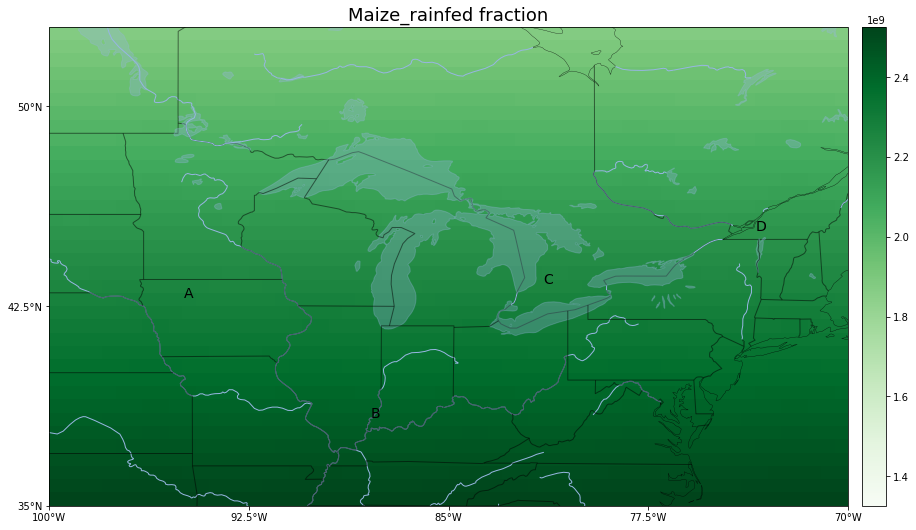

In [31]:
lats = cropped_ds.coords['lat'][:]
lons = cropped_ds.coords['lon'][:]
X,Y = np.meshgrid(lons,lats)
ct_x=[-94.75,-87.75,-81.25,-73.25]
ct_y=[43.25,38.75,43.75,45.75]
ct_n=['A','B','C','D']
projection = ccrs.PlateCarree()
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale='50m', facecolor='none', edgecolor='k')

axes_class = (GeoAxes,
              dict(map_projection=projection))

# lons, lats = np.meshgrid(lons, lats)
title_text=["season=DJF(m/s)", "season=MAM(m/s)", "season=JJA(m/s)", "season=SON(m/s)"]
fig = plt.figure(figsize=(15,15))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.6,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                label_mode='')  # note the empty labe

for i, ax in enumerate(axgr):


#*************************************************************
#add ocean, coastline,borders,lakes,rivers,provinc_bodr
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
    ax.add_feature(cfeature.LAKES, alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(provinc_bodr, linestyle='-', linewidth=1, edgecolor="k", zorder=10, alpha=0.5)    
    ax.set_title('Maize_rainfed fraction',fontsize=18)
    ax.set_xticks(np.linspace(-100, -70, 5), crs=projection)
    ax.set_yticks(np.linspace(35, 65, 5), crs=projection)
    ax.set_xlim([-100,-70])
    ax.set_ylim([35,53])
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
#     #ax.imshow(im, aspect='auto',extent=(-75,-70,35,37),zorder=-1)
#     ax.text(-75,37.5,"yorku.ca/ocdp",fontsize=18)
#     ax.text(-85,60,"Hudson Buy", fontsize=20,color='b',alpha=0.5)

    ax.annotate(ct_n[0], (ct_x[0], ct_y[0]),va="top", ha="center",fontsize=14) 
    ax.annotate(ct_n[1], (ct_x[1], ct_y[1]),va="top", ha="center",fontsize=14) 
    ax.annotate(ct_n[2], (ct_x[2], ct_y[2]),va="top", ha="center",fontsize=14) 
    ax.annotate(ct_n[3], (ct_x[3], ct_y[3]),va="top", ha="center",fontsize=14) 
    p = ax.pcolormesh(X, Y, areainsqmeter,
                      #vmin=0.0,
                      #vmax=50,
                      transform=projection,
                      cmap='Greens')
#     p = ax.contourf(lons, lats, t1m,50,
#                         transform=projection,
#                         cmap='BrBG')
#     ax.scatter(ct_x, ct_y,transform=ccrs.PlateCarree(),color='r')
#     l = ax.contour(lons, lats, t1m,25,colors=['black'], linewidth=0.3,
#                         transform=ccrs.PlateCarree())

#     ax.clabel(
#         l,  # Typically best results when labelling line contours.
#         colors=['black'],
#         manual=False,  # Automatic placement vs manual placement.
#         inline=True,  # Cut the line where the label will be placed.
#         fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
#     )
    
axgr.cbar_axes[0].colorbar(p)
plt.show()


In [32]:
np.save('areainsqmeter_squared_meter_great_lake_region_35N65N.npy',areainsqmeter)